# Plot Connectomes

In [1]:
import nilearn.plotting as nip
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as  cm

/home/stocco/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Load the Power 2011 classification

All of the connectomes in this analysis were extacted from the Power 2011 classification. We will start by first loading the corresponding data table.

In [2]:
power2011 = pd.read_csv("power_2011.csv")
power2011 = power2011.iloc[:,0:7]
power2011

ROI   X   Y   Z  Network  Color       NetworkName
0      1 -25 -98 -12       -1  White         Uncertain
1      2  27 -97 -13       -1  White         Uncertain
2      3  24  32 -18       -1  White         Uncertain
3      4 -56 -45 -24       -1  White         Uncertain
4      5   8  41 -24       -1  White         Uncertain
..   ...  ..  ..  ..      ...    ...               ...
259  260 -27 -71  37       12  Green  Dorsal attention
260  261 -32  -1  54       12  Green  Dorsal attention
261  262 -42 -60  -9       12  Green  Dorsal attention
262  263 -17 -59  64       12  Green  Dorsal attention
263  264  29  -5  54       12  Green  Dorsal attention

[264 rows x 7 columns]

### Visualize the Brain Parcellation

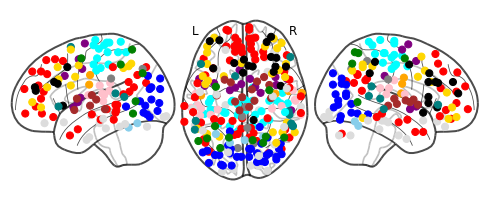

In [3]:
pc = np.zeros((264, 264))
pcol = [x.lower() for x in list(power2011['Color'])]

def colortranslate(x):
    if x.lower() == "yellow":
        return "gold"
    elif x.lower() == "pale blue":
        return "skyblue"
    elif x.lower() == "white":
        return "gainsboro"
    else:
        return x
    
pcol = [colortranslate(x) for x in pcol]
xyz = []
for roi in list(power2011['ROI']):
    entry = power2011.loc[power2011['ROI'] == roi]
    x = int(entry['X'])
    y = int(entry['Y'])
    z = int(entry['Z'])
    xyz.append((x,y,z))
pcoords = np.array(xyz)

img = nip.plot_connectome(pc, pcoords, node_color=pcol, display_mode='lzr')

<ipython-input-4-5f9583950a7d>:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/power2011.png", figsize=(7, 5))


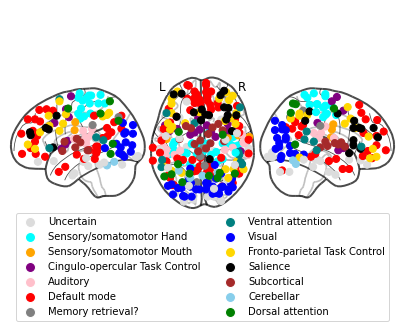

In [4]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
fig, axs = plt.subplots(1,1, figsize=(7,5))
nip.plot_connectome(pc, pcoords, node_color=pcol, display_mode='lzr', axes=axs)

allkols=list(power2011['Color'])
allnets=list(power2011['NetworkName'])

kols=[]
nets=[]
for i in range(len(allkols)):
    if not allkols[i] in kols:
        kols.append(allkols[i])
        nets.append(allnets[i])

handles = [Line2D([0], [0], marker='o', markerfacecolor=x, color="w", markersize=10) for x in [colortranslate(x) for x in kols]]

fig.legend(handles, nets, loc="lower center", ncol=2)
plt.savefig("figures/power2011.png", figsize=(7, 5))
plt.show()

### Visualize the connectome matrix

We can visualize the connectome matrix for the 62 participants. First, we load the data:

In [5]:
subjects = os.listdir("data")

R = np.zeros((264, 264, len(subjects)))
PR = np.zeros((264, 264, len(subjects)))

index = 0
for subj in subjects:
    R[:,:,index]=np.loadtxt("data/%s/R_py.txt" % (subj,))
    PR[:,:,index]=np.loadtxt("data/%s/PR_py.txt" % (subj,))
    index += 1

Then, we visualize it as a matrix

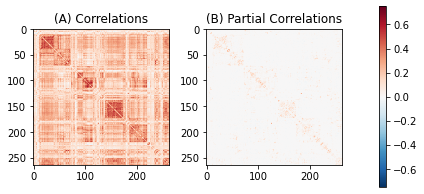

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(6, 3), gridspec_kw={'width_ratios': [20, 20, 1]})
mR = np.mean(R, 2)
mPR = np.mean(PR, 2)

for ii in range(264):
    mR[ii,ii] = 0
    mPR[ii,ii] = 0

im = axs[0].imshow(mR, vmin=-.75, vmax=.75, cmap="RdBu_r")
axs[0].set_title("(A) Correlations")
fig.colorbar(im, cax=axs[2])
axs[1].imshow(mPR, vmin=-0.4, vmax=0.4, cmap="RdBu_r")
axs[1].set_title("(B) Partial Correlations")
#axs[2].set_visible(False)
plt.tight_layout()
plt.savefig("figures/connectomes.png")

### Creating a generic function

Here we assemble all of the steps above into a single function.

In [71]:
### Create a Handy Function

def connectome_visualization(variable, name=None, blackbg=True):
    if name is None:
        name = variable
    # Load the data
    data = pd.read_csv("%s.csv" % (variable,))
    
    # Extract Regions
    ROIs = []

    for c in data['connection']:
        roi1, roi2 = c.split("-")

        if int(roi1) not in ROIs:
            ROIs.append(int(roi1))
        if int(roi2) not in ROIs:
            ROIs.append(int(roi2))
    ROIs.sort()

    # Extra ROI data
    sub = power2011[power2011['ROI'].isin( ROIs)]
    N = len(sub['ROI'])
    connectome = np.zeros((N, N))
    for c in range(N):
        for r in range(N):
            roi1 = ROIs[c]
            roi2 = ROIs[r]
            conn_name = "%d-%d" % (min(roi1, roi2), max(roi1, roi2))
            entry = data.loc[data['connection'] == conn_name]
            if len(entry) == 1:
                beta=float(entry['Beta'])
                connectome[c,r] = beta
            
    plt.imshow(connectome)
    plt.title("Connectome (Beta values)")
    plt.show()

    xyz = []
    sub.loc[:,['X', 'Y', 'Z']]
    for roi in ROIs:
        entry = sub.loc[sub['ROI'] == roi]
        x = int(entry['X'])
        y = int(entry['Y'])
        z = int(entry['Z'])
        xyz.append((x,y,z))
    coords = np.array(xyz)

    colors = []
    sub.loc[:,['Color']]
    for roi in ROIs:
        entry = sub.loc[sub['ROI'] == roi]
        #col = entry['Color']
        col = entry.iloc[0,5]
        colors.append(col.lower())

    nip.plot_connectome(connectome, coords, colorbar=True,
                    title=r"Predictors of %s" % (name,), 
                    black_bg=blackbg, node_color=colors)
    plt.savefig("%s.png" % (variable,))
    nip.show()

    nip.plot_connectome_strength(connectome, coords,
                                 title=r"Importance of ROIs in %s" % (name,))
    plt.savefig("%s_importance.png" % (variable,))
    nip.show()
    
    return connectome, coords, colors


def connectome_visualization_better(variable, name=None, blackbg=True):
    if name is None:
        name = variable
    
    # Load the data
    
    data = pd.read_csv("%s.csv" % (variable,))
    display(data)
    
    # Extract Regions
    
    ROIs = []
    for c in data['connection']:
        roi1, roi2 = c.split("-")

        if int(roi1) not in ROIs:
            ROIs.append(int(roi1))
        if int(roi2) not in ROIs:
            ROIs.append(int(roi2))
    ROIs.sort()

    # Extra ROI data
    
    sub = power2011[power2011['ROI'].isin( ROIs)]
    N = len(sub['ROI'])
    connectome = np.zeros((N, N))
    for c in range(N):
        for r in range(N):
            roi1 = ROIs[c]
            roi2 = ROIs[r]
            conn_name = "%d-%d" % (min(roi1, roi2), max(roi1, roi2))
            entry = data.loc[data['connection'] == conn_name]
            if len(entry) == 1:
                beta=float(entry['Beta'])
                connectome[c,r] = beta
            
    xyz = []
    sub.loc[:,['X', 'Y', 'Z']]
    for roi in ROIs:
        entry = sub.loc[sub['ROI'] == roi]
        x = int(entry['X'])
        y = int(entry['Y'])
        z = int(entry['Z'])
        xyz.append((x,y,z))
    coords = np.array(xyz)
    
    # Figure Legend
    
    colors = []
    sub.loc[:,['Color']]
    for roi in ROIs:
        entry = sub.loc[sub['ROI'] == roi]
        #col = entry['Color']
        col = entry.iloc[0,5]
        colors.append(col.lower())

    # Create Handles for legend
    allkols=list(sub['Color'])
    allnets=list(sub['NetworkName'])


    kols=[]
    nets=[]
    for i in range(len(allkols)):
        if not allkols[i] in kols:
            kols.append(allkols[i])
            nets.append(allnets[i])

    handles = [Line2D([0], [0], marker='o', markerfacecolor=x, color="w", markersize=10) for x in [colortranslate(x) for x in kols]]
    
    # Connectome
    
    fig, axs = plt.subplots(1,1, figsize=(9, 3.5))
    
    emax = max(np.abs(data['Beta']))
    
    nip.plot_connectome(connectome, coords, [colortranslate(x) for x in allkols], 
                    edge_cmap="seismic", axes=axs,
                    display_mode="lzry", colorbar=True, 
                    edge_vmax=emax, edge_vmin=-emax)

    fig.legend(handles, nets, loc="lower center", ncol=3)
    fig.suptitle(r"Neural Correlates of %s" % (name,))
    plt.savefig("figures/%s_pretty.png" % (variable), figsize=(9, 3.5))
    
    # Importance
    
    fig, axs = plt.subplots(1,1, figsize=(9, 3.5))
    nip.plot_connectome_strength(connectome, coords, axes=axs,
                                 cmap="Reds", display_mode="lzry", node_size=100)
    fig.suptitle(r"Importance of ROIs in %s" % (name,))
    plt.savefig("%s_importance.png" % (variable,), figsize=(9, 3.5))
    nip.show()
    
    return connectome, coords, colors

# Zero Back

## Decay rate $d$

We use the new function to plot a different variable, the decay rate $d$

index network                          network_names connection  censor  \
0  31450     1-5  Sensory/somatomotor Hand-Default mode     34-120    True   
1  38870     4-7                        Auditory-Visual     62-148    True   

       Beta  
0 -0.001006  
1 -0.082317

<ipython-input-71-5d33486a3f3e>:154: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/%s_pretty.png" % (variable), figsize=(9, 3.5))
<ipython-input-71-5d33486a3f3e>:162: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("%s_importance.png" % (variable,), figsize=(9, 3.5))


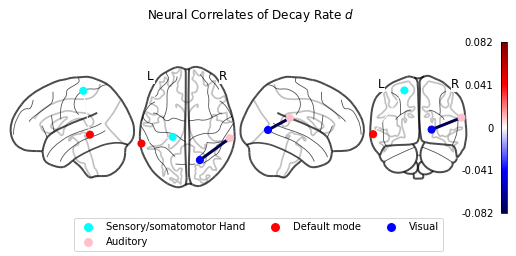

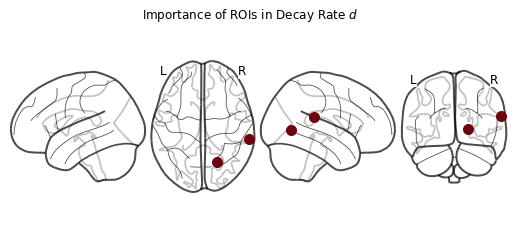

In [72]:
conn, xyz, cols = connectome_visualization_better("bll_0b", "Decay Rate $d$")

## Goal Activation $W_g$

Some prettier visualizations. First, we need to get the network names and colors.

index network                                      network_names  \
0   36994    -1-1                 Uncertain-Sensory/somatomotor Hand   
1   47797    -1-1                 Uncertain-Sensory/somatomotor Hand   
2   59847   -1-10                              Uncertain-Subcortical   
3   62389   -1-11                        Uncertain-Ventral attention   
4   63626   -1-11                        Uncertain-Ventral attention   
..    ...     ...                                                ...   
84  50867     8-8  Fronto-parietal Task Control-Fronto-parietal T...   
85  52712     8-8  Fronto-parietal Task Control-Fronto-parietal T...   
86  52731     8-8  Fronto-parietal Task Control-Fronto-parietal T...   
87  54042     8-9              Fronto-parietal Task Control-Salience   
88  59343    9-10                               Salience-Subcortical   

   connection  censor      Beta  
0      34-141    True -0.052415  
1      13-182    True -0.126170  
2     183-227    True  0.339028  
3      85-237    True -0.079886  
4       2-242    True  0.355454  
..        ...     ...       ...  
84    179-193    True  0.340692  
85    176-200    True  0.001277  
86    195-200    True  0.188850  
87    186-205    True  0.133337  
88    207-225    True -0.178223  

[89 rows x 6 columns]

<ipython-input-71-5d33486a3f3e>:154: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/%s_pretty.png" % (variable), figsize=(9, 3.5))
<ipython-input-71-5d33486a3f3e>:162: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("%s_importance.png" % (variable,), figsize=(9, 3.5))


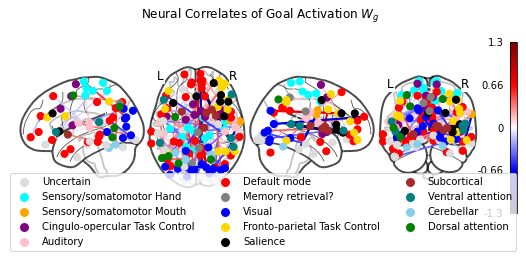

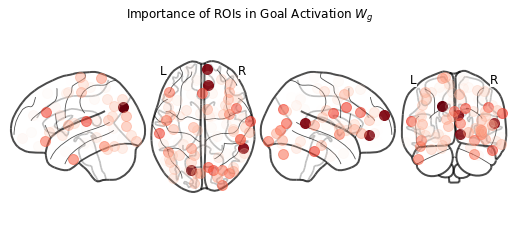

In [73]:
conn, xyz, cols = connectome_visualization_better("ga_0b", "Goal Activation $W_g$")

## Imaginal Activation $W_i$

Here is the data for $W_i$

index network                                      network_names  \
0   7150     1-1  Sensory/somatomotor Hand-Sensory/somatomotor Hand   
1  26686     1-5              Sensory/somatomotor Hand-Default mode   
2  64729    3-13          Cingulo-opercular Task Control-Cerebellar   
3  52142     6-8     Memory retrieval?-Fronto-parietal Task Control   
4  57995     8-9              Fronto-parietal Task Control-Salience   

  connection  censor      Beta  
0      22-28    True  0.007862  
1     22-102    True -0.217305  
2     49-246    True  0.109730  
3    134-198    True -0.294649  
4    179-220    True -0.111168

<ipython-input-71-5d33486a3f3e>:154: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/%s_pretty.png" % (variable), figsize=(9, 3.5))
<ipython-input-71-5d33486a3f3e>:162: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("%s_importance.png" % (variable,), figsize=(9, 3.5))


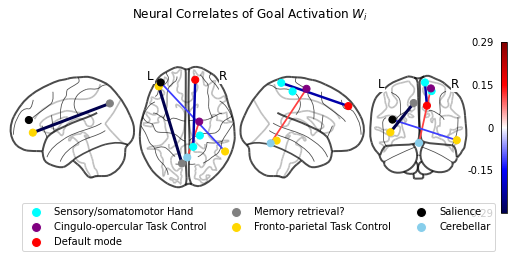

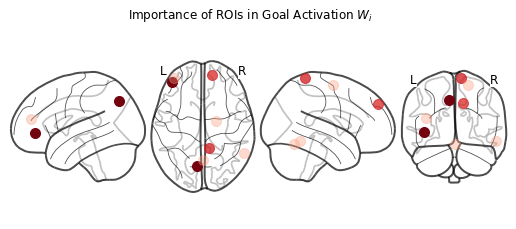

In [74]:
conn, xyz, cols = connectome_visualization_better("ia_0b", "Goal Activation $W_i$")

## Mismatch parameter $M$

Here is the `css` parameter

index network                                   network_names connection  \
0    1850   -1--1                             Uncertain-Uncertain        2-8   
1   37228   -1--1                             Uncertain-Uncertain      4-142   
2   65455   -1--1                             Uncertain-Uncertain    247-248   
3    6076    -1-1              Uncertain-Sensory/somatomotor Hand       4-24   
4   67064    -1-1              Uncertain-Sensory/somatomotor Hand      8-255   
..    ...     ...                                             ...        ...   
61  46345     7-8             Visual-Fronto-parietal Task Control    145-176   
62  51640     7-8             Visual-Fronto-parietal Task Control    160-196   
63  55592     7-9                                 Visual-Salience    152-211   
64  62217    8-11  Fronto-parietal Task Control-Ventral attention    177-236   
65  55098     8-9           Fronto-parietal Task Control-Salience    186-209   

    censor      Beta  
0     True  0.042605  
1     True -0.108303  
2     True -0.005797  
3     True -0.085245  
4     True  0.265120  
..     ...       ...  
61    True  0.097830  
62    True -0.012504  
63    True  0.226301  
64    True -0.080967  
65    True -0.038282  

[66 rows x 6 columns]

<ipython-input-71-5d33486a3f3e>:154: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/%s_pretty.png" % (variable), figsize=(9, 3.5))
<ipython-input-71-5d33486a3f3e>:162: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("%s_importance.png" % (variable,), figsize=(9, 3.5))


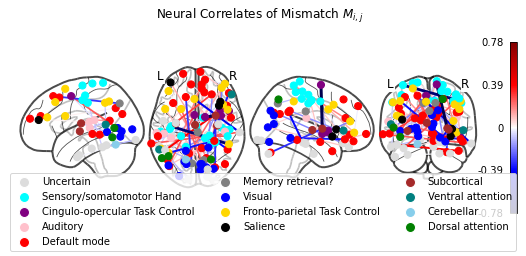

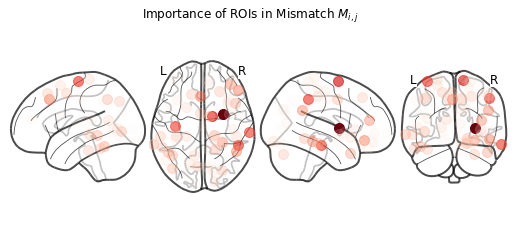

In [76]:
conn, xyz, cols = connectome_visualization_better("css_0b", "Mismatch $M_{i,j}$")

Then, we define the list of network names and corresponding colors

In [28]:
ROIs = []

for conn in bll['connection']:
    roi1, roi2 = conn.split("-")

    if int(roi1) not in ROIs:
        ROIs.append(int(roi1))
    if int(roi2) not in ROIs:
        ROIs.append(int(roi2))
ROIs.sort()

pcol = [colortranslate(x) for x in pcol]

subset = pd.DataFrame(power2011[power2011['ROI'].isin(ROIs)])
print(subset.shape)
subset

(62, 7)


ROI   X   Y   Z  Network  Color               NetworkName
12    13  -7 -52  61        1   Cyan  Sensory/somatomotor Hand
15    16  10  -2  45        1   Cyan  Sensory/somatomotor Hand
18    19  13 -33  75        1   Cyan  Sensory/somatomotor Hand
19    20 -54 -23  43        1   Cyan  Sensory/somatomotor Hand
21    22  10 -46  73        1   Cyan  Sensory/somatomotor Hand
..   ...  ..  ..  ..      ...    ...                       ...
228  229  31 -14   2       10  Brown               Subcortical
238  239  51 -29  -4       11   Teal         Ventral attention
254  255  47 -30  49        1   Cyan  Sensory/somatomotor Hand
260  261 -32  -1  54       12  Green          Dorsal attention
263  264  29  -5  54       12  Green          Dorsal attention

[62 rows x 7 columns]

Now, we use the `subset` to create the list of network names and corresponding colors

In [29]:
allkols=list(subset['Color'])
allnets=list(subset['NetworkName'])

kols=[]
nets=[]
for i in range(len(allkols)):
    if not allkols[i] in kols:
        kols.append(allkols[i])
        nets.append(allnets[i])

handles = [Line2D([0], [0], marker='o', markerfacecolor=x, color="w", markersize=10) for x in [colortranslate(x) for x in kols]]

And now, we visualize that:

<ipython-input-30-77edb320ad56>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/bll_pretty.png", figsize=(7, 4))


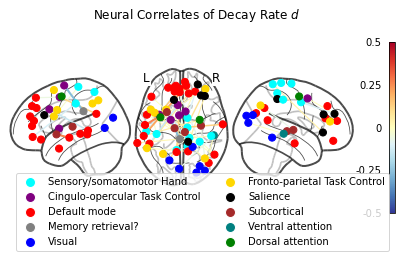

In [30]:
fig, axs = plt.subplots(1,1, figsize=(7, 3.5))

nip.plot_connectome(c, nc, [colortranslate(x) for x in cols], 
                    edge_cmap="RdYlBu_r", axes=axs,
                    display_mode="lzr", colorbar=True, 
                    edge_vmax=0.5, edge_vmin=-0.5)

fig.legend(handles, nets, loc="lower center", ncol=2)
fig.suptitle("Neural Correlates of Decay Rate $d$")
plt.savefig("figures/bll_pretty.png", figsize=(7, 4))
plt.show()

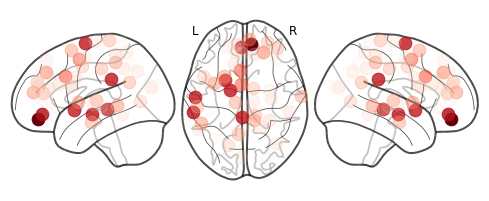

In [31]:
nip.plot_connectome_strength(c, nc, cmap="Reds", display_mode="lzr")
plt.show()

# Spreading Goal Activation $G$

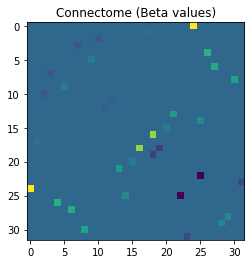

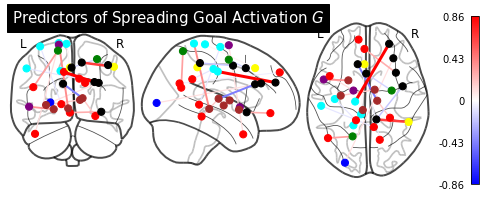

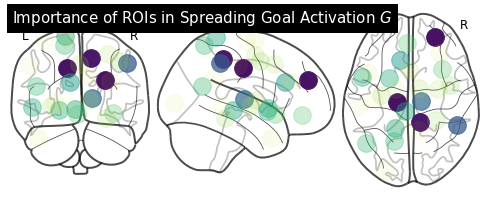

In [32]:
c, nc, cols = connectome_visualization("ga", name=r"Spreading Goal Activation $G$", blackbg=False)
nip.view_connectome(c, nc, colorbar_fontsize=8)

The list of connections

In [33]:
ga = pd.read_csv("ga.csv")
ga

index network                                      network_names  \
0   59438    1-10               Sensory/somatomotor Hand-Subcortical   
1   20101     1-5              Sensory/somatomotor Hand-Default mode   
2   24044     1-5              Sensory/somatomotor Hand-Default mode   
3   53082     1-8  Sensory/somatomotor Hand-Fronto-parietal Task ...   
4   57566     1-9                  Sensory/somatomotor Hand-Salience   
5   61744   10-10                            Subcortical-Subcortical   
6   59722    3-10         Cingulo-opercular Task Control-Subcortical   
7   21170     3-5        Cingulo-opercular Task Control-Default mode   
8   59261    5-10                           Default mode-Subcortical   
9   69247    5-12                      Default mode-Dorsal attention   
10  27021     5-5                          Default mode-Default mode   
11  55549     5-9                              Default mode-Salience   
12  54291     7-9                                    Visual-Salience   
13  53518     8-9              Fronto-parietal Task Control-Salience   
14  59348    9-10                               Salience-Subcortical   
15  69645    9-12                          Salience-Dorsal attention   
16  54059     9-9                                  Salience-Salience   

   connection  censor      Beta  
0      38-226    True  0.386870  
1       37-77    True -0.084073  
2       20-92    True -0.084656  
3      18-202    True  0.037682  
4      14-219    True  0.858578  
5     232-234    True  0.169954  
6      58-227    True  0.360529  
7       50-81    True  0.107477  
8     125-225    True  0.176373  
9      79-263    True  0.316629  
10     93-103    True -0.048049  
11    109-211    True  0.270491  
12    171-206    True  0.102411  
13    190-203    True  0.653969  
14    212-225    True -0.432845  
15    213-264    True -0.153394  
16    203-205    True -0.194222

Create the list of region-specific colors

In [34]:
ROIs = []

for conn in ga['connection']:
    roi1, roi2 = conn.split("-")

    if int(roi1) not in ROIs:
        ROIs.append(int(roi1))
    if int(roi2) not in ROIs:
        ROIs.append(int(roi2))
ROIs.sort()

pcol = [colortranslate(x) for x in pcol]

subset = pd.DataFrame(power2011[power2011['ROI'].isin(ROIs)])

allkols=list(subset['Color'])
allnets=list(subset['NetworkName'])

kols=[]
nets=[]
for i in range(len(allkols)):
    if not allkols[i] in kols:
        kols.append(allkols[i])
        nets.append(allnets[i])

handles = [Line2D([0], [0], marker='o', markerfacecolor=x, color="w", markersize=10) for x in [colortranslate(x) for x in kols]]

subset

ROI   X   Y   Z  Network   Color                     NetworkName
13    14 -14 -18  40        1    Cyan        Sensory/somatomotor Hand
17    18  -7 -33  72        1    Cyan        Sensory/somatomotor Hand
19    20 -54 -23  43        1    Cyan        Sensory/somatomotor Hand
36    37 -38 -15  69        1    Cyan        Sensory/somatomotor Hand
37    38 -16 -46  73        1    Cyan        Sensory/somatomotor Hand
49    50 -16  -5  71        3  Purple  Cingulo-opercular Task Control
57    58 -51   8  -2        3  Purple  Cingulo-opercular Task Control
76    77 -13 -40   1        5     Red                    Default mode
78    79 -46 -61  21        5     Red                    Default mode
80    81 -44  12 -34        5     Red                    Default mode
91    92   8 -48  31        5     Red                    Default mode
92    93  15 -63  26        5     Red                    Default mode
102  103 -10  55  39        5     Red                    Default mode
108  109  -3  44  -9        5     Red                    Default mode
124  125  27 -37 -13        5     Red                    Default mode
170  171 -26 -90   3        7    Blue                          Visual
189  190  49 -42  45        8  Yellow    Fronto-parietal Task Control
201  202  -3  26  44        8  Yellow    Fronto-parietal Task Control
202  203  11 -39  50        9   Black                        Salience
204  205  42   0  47        9   Black                        Salience
205  206  31  33  26        9   Black                        Salience
210  211  34  16  -8        9   Black                        Salience
211  212 -11  26  25        9   Black                        Salience
212  213  -1  15  44        9   Black                        Salience
218  219  26  50  27        9   Black                        Salience
224  225  12 -17   8       10   Brown                     Subcortical
225  226  -5 -28  -4       10   Brown                     Subcortical
226  227 -22   7  -5       10   Brown                     Subcortical
231  232 -31 -11   0       10   Brown                     Subcortical
233  234   9  -4   6       10   Brown                     Subcortical
262  263 -17 -59  64       12   Green                Dorsal attention
263  264  29  -5  54       12   Green                Dorsal attention

And now, connectome:

<ipython-input-35-f6a10b28c8b1>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/ga_pretty.png", figsize=(7, 4))


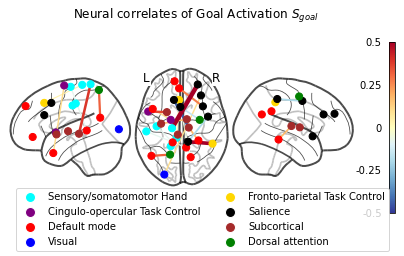

In [35]:
fig, axs = plt.subplots(1,1, figsize=(7, 3.5))

nip.plot_connectome(c, nc, [colortranslate(x) for x in cols], 
                    edge_cmap="RdYlBu_r", axes=axs,
                    display_mode="lzr", colorbar=True, 
                    edge_vmax=0.5, edge_vmin=-0.5)

fig.legend(handles, nets, loc="lower center", ncol=2)
fig.suptitle(r"Neural correlates of Goal Activation $S_{goal}$")
plt.savefig("figures/ga_pretty.png", figsize=(7, 4))
plt.show()

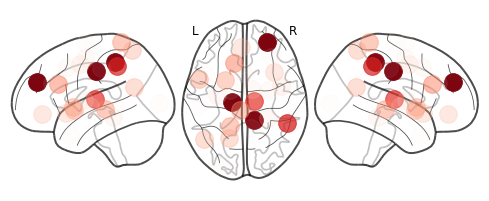

In [36]:
nip.plot_connectome_strength(c, nc, cmap="Reds", display_mode="lzr")
plt.show()